<a href="https://colab.research.google.com/github/thejayden/FYP/blob/main/DCGAN_Pytorch_FID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shutil
from IPython.display import HTML
from torchsummary import summary

from scipy import linalg

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
Let’s define some inputs for the run:

dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section

workers - the number of worker threads for loading the data with the DataLoader
batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128

image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details

nc - number of color channels in the input images. For color images this is 3

nz - length of latent vector

ngf - relates to the depth of feature maps carried through the generator

ndf - sets the depth of feature maps propagated through the discriminator

num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer

lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002

beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5

ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [2]:
path = os.path.join(os.getcwd(), 'train')
if not os.path.isdir('train'):
  os.mkdir(path)
print("Path '% s' created" % path)
os.chdir(path)

!git clone https://github.com/thejayden/gpr_field_data.git
# !git clone -b color https://github.com/thejayden/gpr_field_data.git
# !git clone -b processed_1 https://github.com/thejayden/gpr_field_data.git
# !git clone -b processed_1_crop https://github.com/thejayden/gpr_field_data.git
# !git clone -b processed_1_crop256 https://github.com/thejayden/gpr_field_data.git
# !git clone -b p_1_crop256flip https://github.com/thejayden/gpr_field_data.git

Path '/content/train' created
Cloning into 'gpr_field_data'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (489/489), done.
remote: Compressing objects: 100% (488/488), done.
remote: Total 489 (delta 3), reused 487 (delta 1), pack-reused 0
Receiving objects: 100% (489/489), 8.19 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
sub_path = os.path.join(os.getcwd(), 'gpr_field_data')
# path = os.listdir(path)
for item in os.listdir(sub_path):
  if item.endswith(".git"):    
    shutil.rmtree(os.path.join(sub_path, item), ignore_errors=True)

In [4]:
# os.listdir(sub_path)

In [5]:
# Root directory for dataset
dataroot = path

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 400

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

g_lr = 0.0001
d_lr = 0.0004

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
# print(type(dataroot))
# print(dataroot)

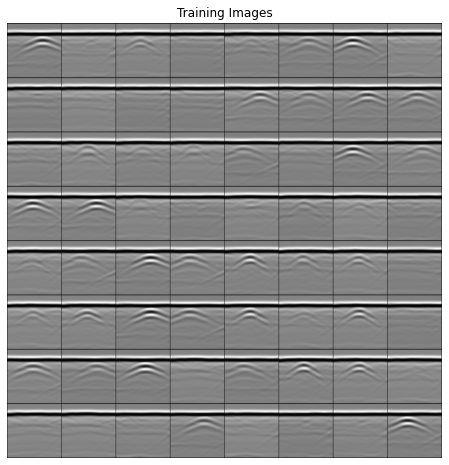

In [7]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                              #  transforms.Resize(image_size),
                              #  transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8 = 2048) x 4 x 4

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4 = 1024) x 8 x 8

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*2 = 512) x 16 x 16

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf = 256) x 32 x 32

            nn.ConvTranspose2d( ngf * 2, int(ngf), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf)),
            nn.ReLU(True),
            # state size. (ngf/2 = 128) x 64 x 64

            nn.ConvTranspose2d( int(ngf), int(ngf/2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf/2)),
            nn.ReLU(True),
            # state size. (ngf/4 = 64) x 128 x 128

            nn.ConvTranspose2d( int(ngf/2), nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc = 3) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# # Generator Code

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# # Print the model
# print(netG)
summary(netG, (400, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       6,553,600
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, int(ndf/2), 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(int(ndf/2), ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
summary(netD, (3, 256, 256))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0
"""adding label smoothing"""
real_label=0.9
fake_label=0.1

# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

In [15]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
# model=model.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [16]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [17]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [18]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=False)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=False)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [19]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))

Generator Parameters: 17733056
Discriminator Parameters: 11195776


Starting Training Loop...
[5/5]	Loss_D: 60.7231	Loss_G: 45.2657	Fretchet_Distance: 319.7791


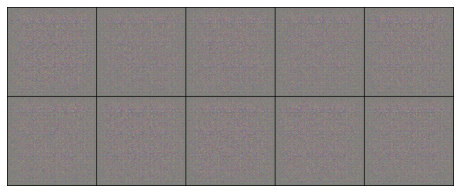

In [20]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
#         # add some noise to the input to discriminator
        
        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()
        
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))
            
         
            
        iters += 1   
    G_losses.append(errG.item())
    D_losses.append(errD.item())     
    fretchet_dist=calculate_fretchet(real_cpu,fake,model) 
    if ((epoch+1)%5==0):
        
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))
        
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

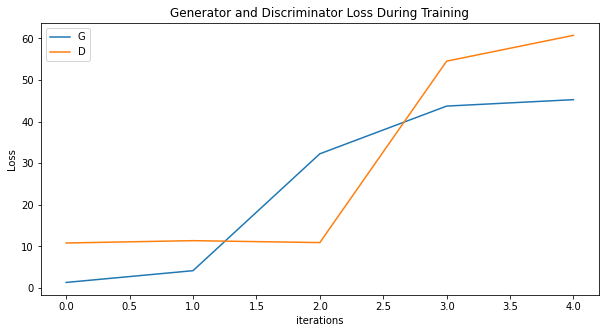

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

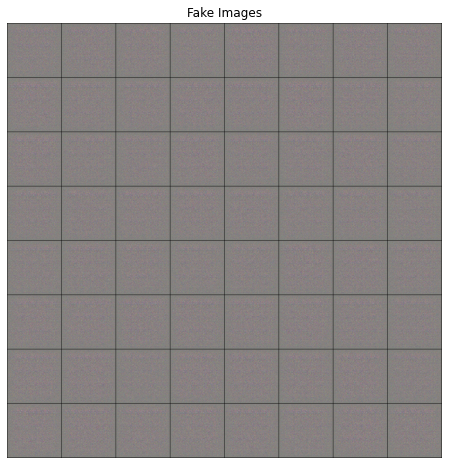

In [22]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()